In [1]:
import pandas as pd
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
time_pr = pd.read_csv('../data/TimeProvince.csv')
pat_info = pd.read_csv('../data/PatientInfo.csv')
time = pd.read_csv('../data/Time.csv')
weather = pd.read_csv('../data/Weather.csv')
region = pd.read_csv('../data/Region.csv')
time_age = pd.read_csv('../data/TimeAge.csv')
time_gndr = pd.read_csv('../data/TimeGender.csv')
policy = pd.read_csv('../data/Policy.csv')
pat_rte =  pd.read_csv('../data/PatientRoute.csv')
srch_trnd = pd.read_csv('../data/SearchTrend.csv')
case = pd.read_csv('../data/Case.csv')
seoul = pd.read_csv('../data/SeoulFloating.csv')

In [3]:
pat_info['deceased_flag'] = np.where(pat_info['state'] == 'deceased',1,0)

In [4]:
death_rate = pat_info['deceased_flag'].value_counts()[1]*100/pat_info.shape[0]

print('사망률 :',round(death_rate,2),'%')

사망률 : 1.85 %


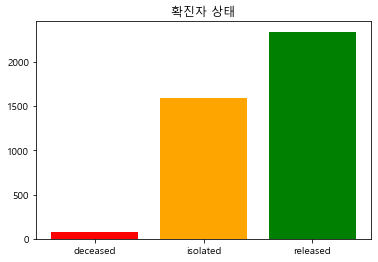

In [5]:
pat_state = pat_info[['state','patient_id']].groupby('state').count().reset_index().sort_values(by = 'patient_id')

plt.bar(pat_state.state, pat_state.patient_id, color=['red','orange','green'])
plt.title('확진자 상태')
plt.show()

- 대부분의 환자들이 죽기보단 격리해제되었다.
- 또한 많은 확진자들을 격리하여 전염을 억제하고 있다.

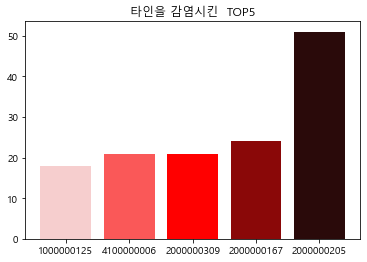

In [6]:
pat_by_contact = pat_info[pat_info['infection_case'] == 'contact with patient']
contact_other = pat_by_contact[['infected_by','patient_id']].groupby('infected_by').count().reset_index().sort_values(by = 'patient_id', ascending = False)[0:5]
contact_other.sort_values(by =  'patient_id',  inplace =True)

plt.bar(contact_other.infected_by, contact_other.patient_id, color=['#F6CECE','#FA5858','#FF0000','#8A0808','#2A0A0A'])
plt.title('타인을 감염시킨  TOP5')
plt.show()

- 위 환자들은 슈퍼 전파자이다.
- 그 중 1등이 2000000205번 환자이다.

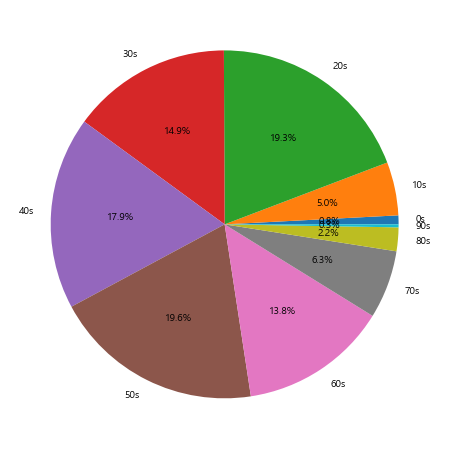

In [7]:
contact_other = pat_by_contact[['infected_by','patient_id']].groupby('infected_by').count().reset_index().sort_values(by = 'patient_id', ascending = False)
spreader_list = []
for num in list(contact_other['infected_by']):
    if len(num) == 10:
        spreader_list.append(int(num))
spreader_df = pat_info[pat_info['patient_id'] == spreader_list[0]]
for i in range(1,len(spreader_list)):
    spreader_df = spreader_df.append(pat_info[pat_info['patient_id'] == spreader_list[i]])
spreader_age = spreader_df.groupby('age').patient_id.count()
spreader_sex = spreader_df.groupby('sex').patient_id.count()

plt.figure(figsize=(8, 8))
plt.pie(spreader_age.values, labels=spreader_age.index, autopct='%0.1f%%')
plt.xticks(rotation=90)
plt.show()

- 타인을 감염시킨 사람은 20,30,40,50대에서 골고루 많이 나타났다.

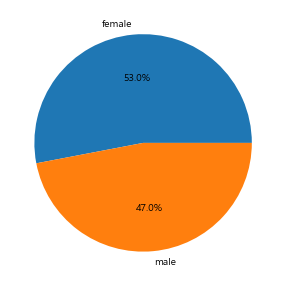

In [8]:
plt.figure(figsize=(5, 5))
plt.pie(spreader_sex.values, labels=spreader_sex.index, autopct='%0.1f%%')
plt.xticks(rotation=90)
plt.show()

- 타인을 감염시킨 사람은 여자와 남자의 비율이 비슷하다.

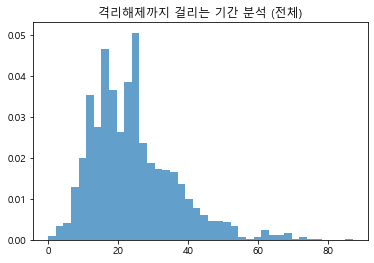

In [69]:
from datetime import datetime

released = pat_info[pat_info['state'] == 'released']
released = released[released['released_date'].notna()]
released = released[released['confirmed_date'].notna()]

d2 = list(released['released_date'])

d1 = list(released['confirmed_date'])

n = len(d1)

diff = [abs(datetime.strptime(d2[i], "%Y-%m-%d")- datetime.strptime(d1[i], "%Y-%m-%d")).days  for  i  in range(0,n)]

released.insert(0,'diff',diff)

plt.hist(released['diff'], bins=40, alpha=0.7, density = True)
plt.title('격리해제까지 걸리는 기간 분석 (전체)')
plt.show()

- 격리해제까지 걸리는 시간은 0시간에서 80일 이상까지 다양하게 나타난다.
- 하지만 주로 14일~28일의 시간이 소요되는 것으로 보인다.

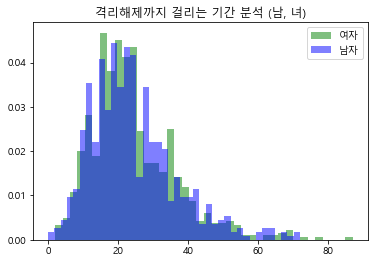

In [96]:
plt.hist(released['diff'][released['sex']=='female'], bins=40, alpha=0.5, color='green', label='여자', density = True)
plt.hist(released['diff'][released['sex']=='male'], bins=40, alpha=0.5, color='blue', label='남자', density = True)
plt.title('격리해제까지 걸리는 기간 분석 (남, 녀)')
plt.legend()
plt.show()

- 격리 해제까지 걸리는 기간은 남녀와 상관없이 비슷한 분포를 가진다.

In [97]:
over_time = pat_info[['confirmed_date','state','patient_id']].groupby(['confirmed_date','state']).count().reset_index()
over_time = over_time.pivot_table(index = ['confirmed_date'], columns = ['state'], values=['patient_id'])

over_time.fillna(0, inplace = True)

over_time.columns = ['deceased','isolated','released']

over_time['Total'] = over_time.sum(axis = 1)

over_time.insert(0,'Date',over_time.index.values)

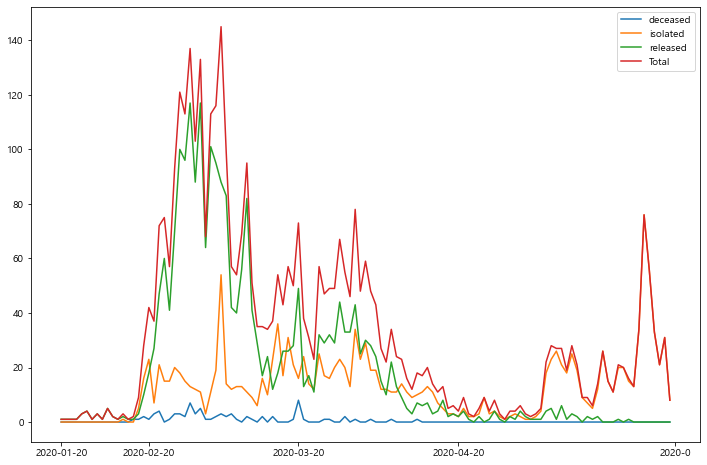

In [98]:
plt.figure(figsize=(12, 8))
plt.plot(over_time['Date'], over_time['deceased'], label='deceased')
plt.plot(over_time['Date'], over_time['isolated'], label='isolated')
plt.plot(over_time['Date'], over_time['released'], label='released')
plt.plot(over_time['Date'], over_time['Total'], label='Total')
plt.xticks(['2020-01-20', '2020-02-20', '2020-03-20', '2020-04-20', '2020-0'])
plt.legend()
plt.show()

- 3월에 가장 높은 사망자를 기록했다.
- 발생초기에는 Total 그래프가 격리해제 그래프와 비슷한 양상을 띈다.
- 하지만 발생후기(4월말~5월)에는 Total 그래프가 격리 그래프와 더 비슷한 양상을 띈다.
- 이는 한국의 격리 조치가 더 강해졌음을 의미한다.

In [100]:
pted =  time_gndr.pivot_table(index = ['date'],columns =['sex'],values =['confirmed','deceased'])

pted.columns = ['confirmed_female','confirmed_male', 'deceased_female','deceased_male']

pted.insert(0,'date',pted.index.values)

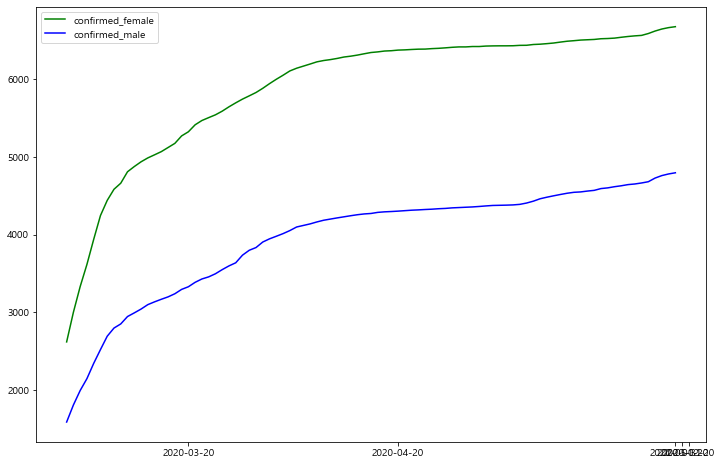

In [101]:
plt.figure(figsize=(12, 8))
plt.plot(pted['date'], pted['confirmed_female'], label='confirmed_female', color='green')
plt.plot(pted['date'], pted['confirmed_male'], label='confirmed_male', color='blue')
plt.xticks(['2020-01-20', '2020-02-20', '2020-03-20', '2020-04-20', '2020-05-31'])
plt.legend()
plt.show()

- 확진자는 남성보다 여성이 더 많다.

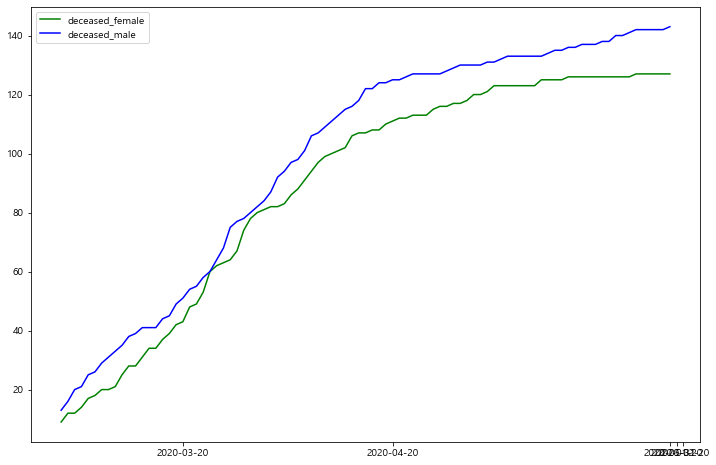

In [102]:
plt.figure(figsize=(12, 8))
plt.plot(pted['date'], pted['deceased_female'], label='deceased_female', color='green')
plt.plot(pted['date'], pted['deceased_male'], label='deceased_male', color='blue')
plt.xticks(['2020-01-20', '2020-02-20', '2020-03-20', '2020-04-20', '2020-05-31'])
plt.legend()
plt.show()

- 사망자 수는 비슷하다.

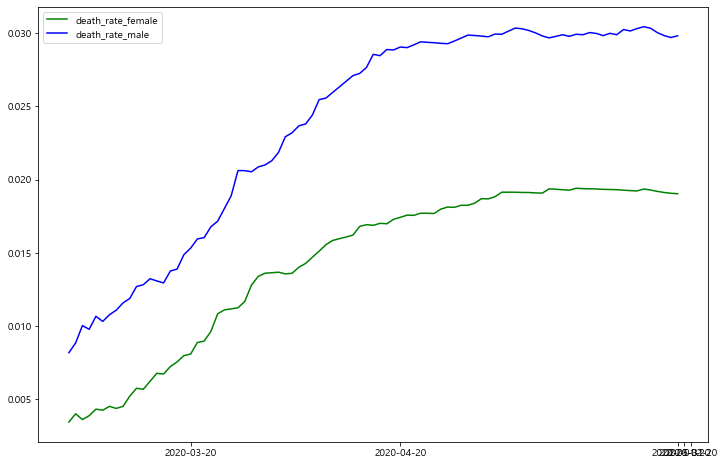

In [103]:
plt.figure(figsize=(12, 8))
plt.plot(pted['date'], pted['deceased_female'] / pted['confirmed_female'], label='death_rate_female', color='green')
plt.plot(pted['date'], pted['deceased_male'] / pted['confirmed_male'], label='death_rate_male', color='blue')
plt.xticks(['2020-01-20', '2020-02-20', '2020-03-20', '2020-04-20', '2020-05-31'])
plt.legend()
plt.show()

- 결론 : 사망률은 남성이 더 높다.